# Настройка collab

In [ ]:
!pip install kaggle pymorphy2

In [ ]:
import json
import os

In [ ]:
if not os.path.isdir('/root/.kaggle'):
    os.makedirs('/root/.kaggle')
with open('/root/.kaggle/kaggle.json', 'w') as file:
    json.dump({"username": "", "key": ""}, file)

In [ ]:
!chmod 600 "/root/.kaggle/kaggle.json"

In [ ]:
if not os.path.isdir('data'):
    os.makedirs('data')

In [ ]:
!kaggle competitions download -c nlp-workshop-diagnosis-prediction --path data

# Local

In [1]:
import zipfile

In [2]:
import numpy as np
import pandas as pd

In [3]:
import matplotlib.pyplot as plt

In [4]:
%matplotlib inline

In [91]:
pd.options.display.max_columns = 50
pd.options.display.max_colwidth = 500

# Read data

In [6]:
with zipfile.ZipFile("data/train.csv.zip") as z:
    names = z.namelist()
    print(f"names: {names}")
    with z.open(names[0]) as f:
        pd_train = pd.read_csv(f, index_col=0)
        
with zipfile.ZipFile("data/test.csv.zip") as z:
    names = z.namelist()
    print(f"names: {names}")
    with z.open(names[0]) as f:
        pd_test = pd.read_csv(f, index_col=0)
        
pd_sample = pd.read_csv("data/sample_submission.csv")

names: ['train.csv']
names: ['test.csv']


In [7]:
pd_train.head(2)

,Id_Пациента,Возраст,Диагноз,Жалобы,Источник_рекламы,Клиника,Код_диагноза,Пол,Услуга
0,115819,54,Гипертензивная болезнь сердца [гипертоническая...,"на повышение ад утром до 140/90 мм.рт.ст., пер...",Другое,5,I11,2,"Прием врача-кардиолога повторный, амбулаторный"
1,399973,32,Доброкачественное новообразование молочной железы,На наличие опухоли в левой молочной железе,Другое,3,D24,2,"Прием врача-онколога (маммолога), повторный, а..."


In [8]:
pd_test.head(2)

,Id_Пациента,Возраст,Жалобы,Источник_рекламы,Клиника,Пол,Услуга
0,598841,43,на момент осмотра не предъявляет,Рекомендации знакомых,5,2,"Прием врача-акушера-гинеколога повторный, амбу..."
1,596613,37,"На слабость, головную боль, на расфокусировку ...",Зарегистрировался на сайте,3,1,"Прием врача-кардиолога повторный, амбулаторный"


In [9]:
pd_sample.head(2)

,index,Код_диагноза
0,0,J06.9
1,1,J06.9


In [10]:
pd_train.shape, pd_test.shape, pd_sample.shape

((49619, 9), (12021, 7), (12021, 2))

# Target

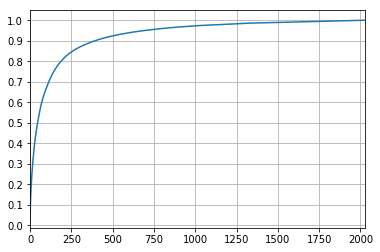

In [11]:
pd_train["Код_диагноза"].value_counts(normalize=True).cumsum().reset_index(drop=True) \
    .plot(grid=True, yticks=np.arange(0, 1.01, 0.1))

In [12]:
target_dict = pd_train["Код_диагноза"].value_counts().reset_index()["index"]
target_dict = target_dict.reset_index().set_index("index")
target_dict.iloc[1200:] = -1
target_dict_code2ix = target_dict['level_0'].to_dict()
target_dict_ix2code = {v: k for k, v in target_dict_code2ix.items() if v >= 0}

Оставляем 1200 фичей, что покрывает более 98% примеров. Остальное выбрасываем.
Если выбросить больше, то тереям в качестве (выброшенные классы могли хорошо предсказываться)
Если выбросить меньше, то остаются классы, где пример всего один.

In [13]:
pd_train["y"] = pd_train["Код_диагноза"].map(target_dict_code2ix)

In [14]:
X = pd_train.loc[pd_train["y"].ge(0), ["Id_Пациента", "Возраст", "Жалобы", "Источник_рекламы", "Клиника", "Пол", "Услуга"]].copy()
y = pd_train.loc[pd_train["y"].ge(0), "y"].values

In [15]:
X.shape, y.shape

((48681, 7), (48681,))

In [16]:
from sklearn.model_selection import train_test_split
i_train, i_test = train_test_split(np.arange(y.shape[0]), test_size=0.3, stratify=y)

# Features

In [20]:
from sklearn.base import BaseEstimator, TransformerMixin

In [21]:
class ColumnSelector(BaseEstimator, TransformerMixin):
    def __init__(self, col_name):
        self.col_name = col_name
        
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        return X[self.col_name].values

## MorphAnalyzer

In [22]:
from pymorphy2 import MorphAnalyzer

In [23]:
morph = MorphAnalyzer()

In [24]:
morph.parse("раму")

[Parse(word='раму', tag=OpencorporaTag('NOUN,inan,masc,Geox sing,datv'), normal_form='рам', score=0.5, methods_stack=((<DictionaryAnalyzer>, 'раму', 32, 2),)),
 Parse(word='раму', tag=OpencorporaTag('NOUN,inan,femn sing,accs'), normal_form='рама', score=0.5, methods_stack=((<DictionaryAnalyzer>, 'раму', 55, 3),))]

In [25]:
import re

In [26]:
class Normalizer(BaseEstimator, TransformerMixin):
    """Приводит слова к нормальной форме.
    
    `_cache` нужен чтобы ускорить обработку. Словарь небольшой (порядка 2000 слов), памяти на кеш много не нужно.
    """
    _cache = {}
    
    @staticmethod
    def _process(line):
        def norm(word):
            if word in Normalizer._cache:
                return Normalizer._cache[word]
            
            n = morph.parse(word)[0].normal_form
            Normalizer._cache[word] = n
            
            return n
        
        return " ".join([norm(word) for word in re.findall(r"\w+", line.lower())])
    
    def __init__(self):
        pass
        
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        return np.array([self._process(line) for line in X])

In [27]:
Normalizer().fit_transform(["Мама мыла- раму", "Папа чинил сапоги"])

array(['мама мыло рам', 'папа чинить сапог'], dtype='<U17')

## Услуга

In [28]:
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer

In [29]:
pipe_service = Pipeline([
    ('select', ColumnSelector("Услуга")),
    ('norm', Normalizer()),
    ('tfidf', TfidfVectorizer()),
])

In [30]:
%%time
# pipe_service.set_params(tfidf__token_pattern=r"\b\w{,5}")
X_service = pipe_service.fit_transform(X)

CPU times: user 604 ms, sys: 21.6 ms, total: 626 ms
Wall time: 625 ms


In [31]:
X_service.shape

(48681, 241)

In [ ]:
pipe_service.named_steps["tfidf"].vocabulary_

## Жалоба

In [33]:
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer

In [34]:
pipe_symptom = Pipeline([
    ('select', ColumnSelector("Жалобы")),
    ('norm', Normalizer()),
    ('tfidf', TfidfVectorizer(min_df=4, max_df=0.6, max_features=10000)),
])

In [35]:
%%time
# pipe_service.set_params(tfidf__token_pattern=r"\b\w{,5}")
X_symptom = pipe_symptom.fit_transform(X)

CPU times: user 1.46 s, sys: 36.6 ms, total: 1.5 s
Wall time: 1.5 s


In [36]:
X_symptom.shape

(48681, 2221)

In [37]:
X_symptom

<48681x2221 sparse matrix of type '<class 'numpy.float64'>'
	with 333412 stored elements in Compressed Sparse Row format>

In [ ]:
pipe_symptom.named_steps["tfidf"].vocabulary_

## Клиника

In [39]:
X["Клиника"].value_counts()

3     34445
6      5541
5      5407
2      3128
15      158
19        2
Name: Клиника, dtype: int64

In [40]:
from sklearn.preprocessing import OneHotEncoder

In [41]:
pipe_clinic = Pipeline([
    ('select', ColumnSelector(["Клиника"])),
    ('ohe', OneHotEncoder(sparse=False, categories='auto', handle_unknown="ignore")),
])

In [42]:
X_clinic = pipe_clinic.fit_transform(X)

In [43]:
X_clinic.shape

(48681, 6)

In [44]:
X_clinic

array([[0., 0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0.],
       ...,
       [0., 1., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0.]])

## Пол

In [45]:
X["Пол"].value_counts()

2    33754
1    14927
Name: Пол, dtype: int64

In [46]:
from sklearn.preprocessing import OneHotEncoder

In [47]:
pipe_sex = Pipeline([
    ('select', ColumnSelector(["Пол"])),
    ('ohe', OneHotEncoder(sparse=False, categories='auto', handle_unknown="ignore")),
])

In [48]:
X_sex = pipe_sex.fit_transform(X)

In [49]:
X_sex.shape

(48681, 2)

In [50]:
X_sex

array([[0., 1.],
       [0., 1.],
       [0., 1.],
       ...,
       [0., 1.],
       [0., 1.],
       [0., 1.]])

## Возраст

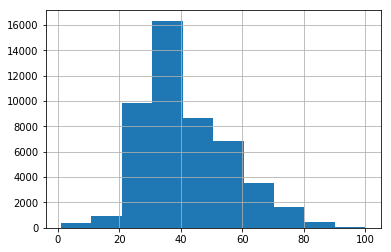

In [51]:
X["Возраст"].clip(0, 100).hist()

In [52]:
class ClipTransformer(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass
        
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        return np.clip(X, 0, 100)

In [53]:
from sklearn.preprocessing import MinMaxScaler

In [54]:
pipe_age = Pipeline([
    ('select', ColumnSelector(["Возраст"])),
    ('clip', ClipTransformer()),
    ('norm', MinMaxScaler()),
])

In [55]:
X_age = pipe_age.fit_transform(X)

/data/ruanvd3/miniconda3/envs/venv36/lib/python3.6/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)


In [56]:
X_age.shape

(48681, 1)

In [57]:
X_age

array([[0.53535354],
       [0.31313131],
       [0.71717172],
       ...,
       [0.67676768],
       [0.29292929],
       [0.24242424]])

## Источник_рекламы

In [58]:
X["Источник_рекламы"].value_counts()

Другое                                 29045
Интернет                                8570
Рекомендации знакомых                   7054
Зарегистрировался на сайте              1265
Живет-работает рядом                     844
Страховая                                422
Щиты,уличная реклама                     390
Рекомендации к доктору                   317
Кутузовский                              156
Гефест                                   117
Врач Бегма Андрей Николаевич              47
Листовки                                  33
Кунцево                                   30
дельта                                    23
не назвала                                23
ООО Дельта                                21
ДМС                                       21
Врач Суван-оол Марина Анатольевна         19
Уклеина Наталья Григорьевна               15
Радио                                     14
Сайт ИП Веревошников                      14
МедЭлит                                   13
Врач Чабан

In [59]:
from sklearn.preprocessing import OneHotEncoder

In [60]:
pipe_adv = Pipeline([
    ('select', ColumnSelector(["Источник_рекламы"])),
    ('ohe', OneHotEncoder(sparse=False, handle_unknown="ignore")),
])

In [61]:
X_adv = pipe_adv.fit_transform(X)

In [62]:
X_adv

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [63]:
X_adv.shape

(48681, 114)

## Client

Среди жалоб встречатся "прежние". Непонятно что из этого следует.
Для больше ясности надо посмотреть жалобы от предыдущих приемов. Соберем все жалобы от всех приемов и добавим их отдельным полем `Жалобы_2`.
На всякий случай, добавим историю услуг - это был тот же самый врач, или другой. Все услуги, которые оказывались клиенту в поле `Услуга_2`

In [ ]:
pd_train[pd_train["Id_Пациента"].isin(pd_train["Id_Пациента"].value_counts()
                                      [pd_train["Id_Пациента"].value_counts().eq(2)].index)] \
    .sort_values("Id_Пациента")

In [224]:
def append_other_rows(df, field, exclude_self=True):
    """Добавляет новое поле '{field}_2', в котором записывает значения из поля '{field}',
    которое встречается в других записях этого клиента.
    
    :param exclude_self: Если True, то текущая жадоба не входит в Жалобы_2.
        Иначе Жалобы_2 включает в себя текст из текущей жалобы.
    """
    new_field = f"{field}_2"
    t = pd.merge(df["Id_Пациента"],
                 df.groupby("Id_Пациента")[field].agg(lambda x: {k: v for k, v in x.items()}).rename(new_field),
                 left_on="Id_Пациента", right_index=True)
    t[new_field] = t.apply(lambda x: " ".join([v for k, v in x[new_field].items() if x.name != k or not exclude_self]), axis=1)
    df[new_field] = t[new_field]

In [225]:
append_other_rows(X, "Жалобы", exclude_self=False)
append_other_rows(X, "Услуга", exclude_self=False)

append_other_rows(pd_test, "Жалобы", exclude_self=False)
append_other_rows(pd_test, "Услуга", exclude_self=False)

In [ ]:
X

In [227]:
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer

In [228]:
pipe_symptom2 = Pipeline([
    ('select', ColumnSelector("Жалобы_2")),
    ('norm', Normalizer()),
    ('tfidf', pipe_symptom.named_steps["tfidf"]),  # исользуем старый tfidf
])

In [229]:
%%time
X_symptom2 = pipe_symptom2.transform(X)

CPU times: user 3.88 s, sys: 83.1 ms, total: 3.97 s
Wall time: 3.96 s


In [230]:
X_symptom2.shape

(48681, 2221)

In [231]:
X_symptom2

<48681x2221 sparse matrix of type '<class 'numpy.float64'>'
	with 1166981 stored elements in Compressed Sparse Row format>

In [ ]:
pipe_symptom2.named_steps["tfidf"].vocabulary_

In [233]:
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer

In [234]:
pipe_service2 = Pipeline([
    ('select', ColumnSelector("Услуга_2")),
    ('norm', Normalizer()),
    ('tfidf', pipe_service.named_steps["tfidf"]),
])

In [235]:
%%time
X_service2 = pipe_service2.transform(X)

CPU times: user 2.34 s, sys: 54 ms, total: 2.39 s
Wall time: 2.39 s


In [236]:
X_service2.shape

(48681, 241)

In [ ]:
pipe_service2.named_steps["tfidf"].vocabulary_

# NN

In [64]:
import keras
import keras.backend as K
from keras import layers
from keras import Model

Using TensorFlow backend.


In [65]:
import tensorflow as tf
from keras.backend.tensorflow_backend import set_session

config = tf.ConfigProto()
config.gpu_options.allow_growth = True
config.log_device_placement = True
session = tf.Session(config=config)
set_session(tf.Session(config=config))

In [66]:
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

In [297]:
def get_model():
    i_service = layers.Input(shape=(X_service.shape[1],), name="service")
    i_service2 = layers.Input(shape=(X_service2.shape[1],), name="service2")
    i_clinic = layers.Input(shape=(X_clinic.shape[1],), name="clinic")

    i_adv = layers.Input(shape=(X_adv.shape[1],), name="adv")
    l_adv = layers.Dense(32, activation="relu")(i_adv)
    l_adv = layers.BatchNormalization()(l_adv)

    i_sex = layers.Input(shape=(X_sex.shape[1],), name="sex")
    i_age = layers.Input(shape=(X_age.shape[1],), name="age")
    
    i_sym = layers.Input(shape=(X_symptom.shape[1],))
    l_sym = layers.Dropout(0.2)(i_sym)
    l_sym = layers.Dense(256, activation="relu", kernel_regularizer=keras.regularizers.l2(0.005))(l_sym)
    l_sym = layers.BatchNormalization()(l_sym)
    m_sym = Model(inputs=i_sym, outputs=l_sym)    

    i_symptom = layers.Input(shape=(X_symptom.shape[1],), name="symptom")
    l_symptom = m_sym(i_symptom)

    i_symptom2 = layers.Input(shape=(X_symptom2.shape[1],), name="symptom2")
    l_symptom2 = m_sym(i_symptom2)

    h_m1 = layers.concatenate([i_service, i_clinic])
    h_m1 = layers.Dense(64, name="h_service")(h_m1)
    h_m1 = layers.BatchNormalization()(h_m1)
    
    h_m2 = layers.concatenate([i_sex, i_age])
    h_m2 = layers.Dense(64, name="h_person")(h_m2)
    h_m2 = layers.BatchNormalization()(h_m2)
    
    h_merge = layers.concatenate([h_m1, l_adv, h_m2])
    h_merge = layers.Dropout(0.2)(h_merge)
    h_merge = layers.Dense(256, activation="relu")(h_merge)
    h_merge = layers.BatchNormalization()(h_merge)
    
    h_m3 = layers.concatenate([i_service, i_service2])
    h_m3 = layers.Dense(64, activation="relu", name="h_service_all")(h_m3)
    h_m3 = layers.BatchNormalization()(h_m3)

    h_merge2 = layers.concatenate([h_merge, l_symptom, l_symptom2, h_m3])
    h_merge2 = layers.BatchNormalization()(h_merge2)
    h_merge2 = layers.Dropout(0.4)(h_merge2)
    h_merge2 = layers.Dense(768, activation="relu")(h_merge2)
    h_merge2 = layers.Dropout(0.5)(h_merge2)

    o_diagnosis = layers.Dense(1200, activation="softmax")(h_merge2)

    model = Model(inputs=[i_service, i_service2, i_clinic, i_adv, i_sex, i_age, i_symptom, i_symptom2],
                  outputs=[o_diagnosis])
    
    model.compile(optimizer=keras.optimizers.adam(lr=0.0005 / 2, decay=0.0001),
              metrics=["categorical_accuracy"], loss="categorical_crossentropy")
    
    return model

In [292]:
model = get_model()

In [293]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
service (InputLayer)            (None, 241)          0                                            
__________________________________________________________________________________________________
clinic (InputLayer)             (None, 6)            0                                            
__________________________________________________________________________________________________
sex (InputLayer)                (None, 2)            0                                            
__________________________________________________________________________________________________
age (InputLayer)                (None, 1)            0                                            
__________________________________________________________________________________________________
concatenat

In [308]:
from keras.utils import plot_model
plot_model(model, to_file='model.png', show_shapes=True)

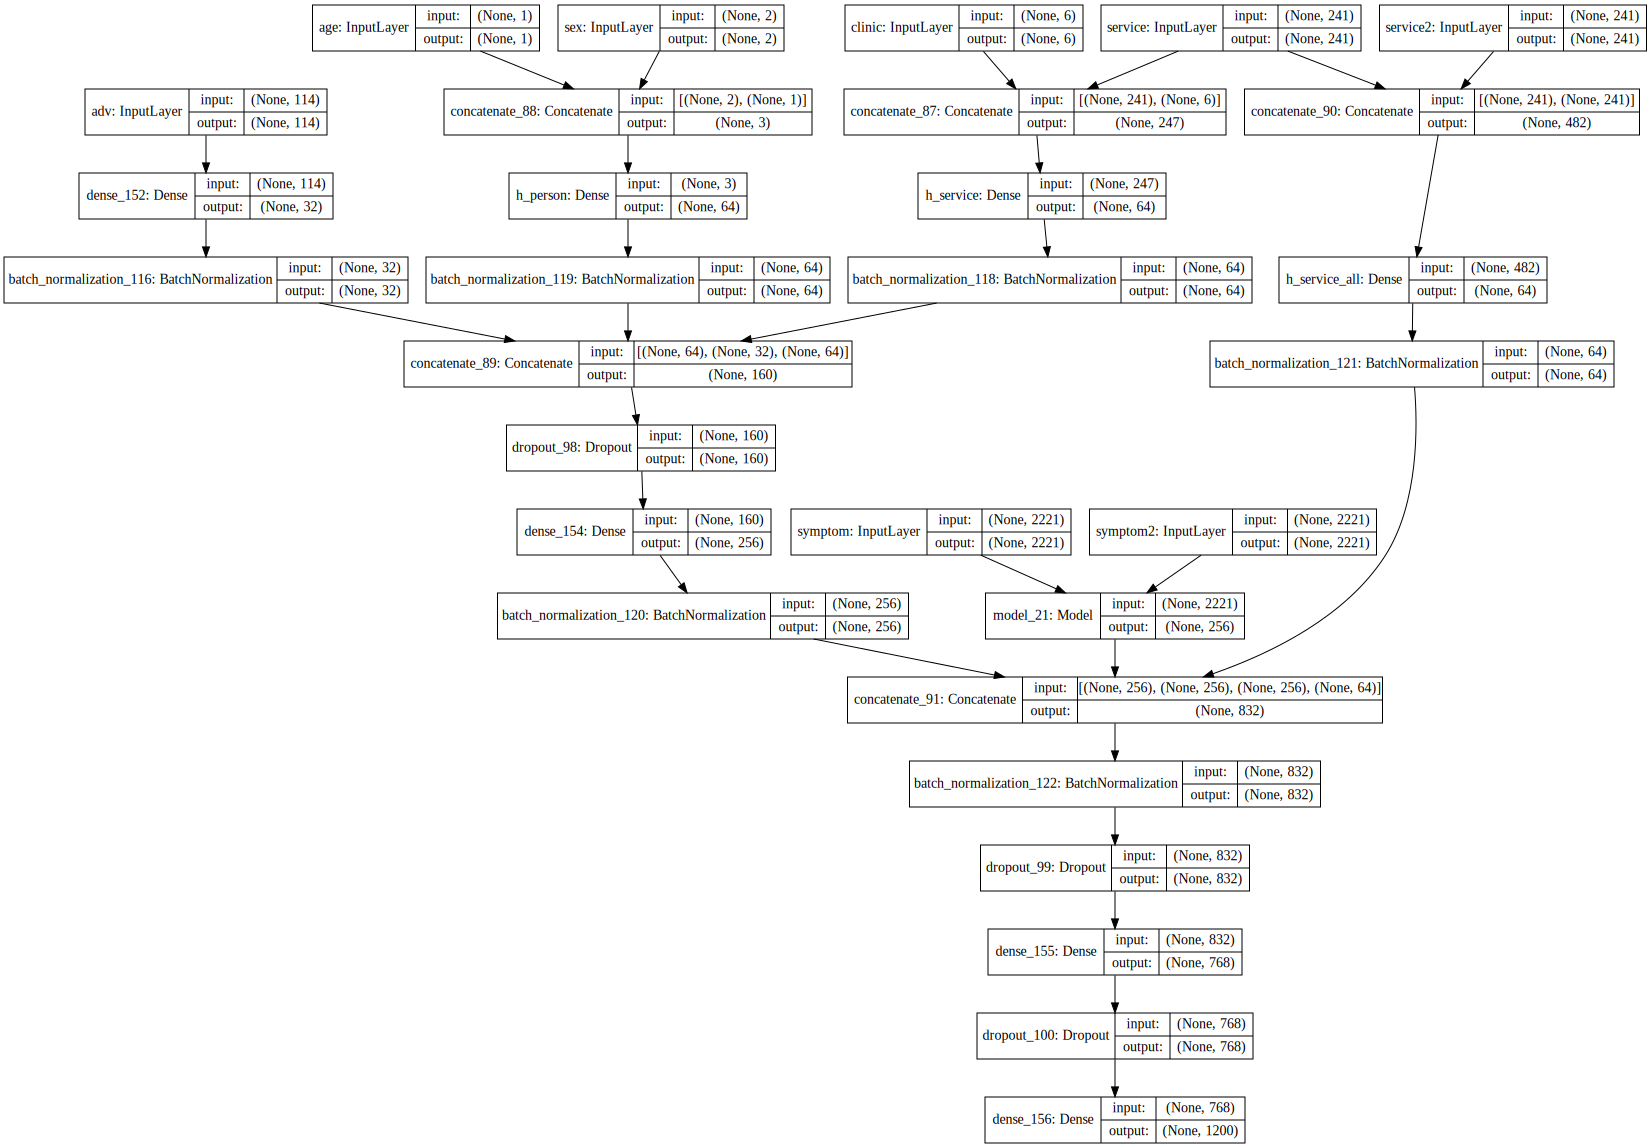

In [294]:
SVG(model_to_dot(model, show_shapes=True).create(prog='dot', format='svg'))

In [295]:
X_input = [X_service, X_service2, X_clinic, X_adv, X_sex, X_age, X_symptom, X_symptom2]

X_train = [m[i_train] for m in X_input]
X_test = [m[i_test] for m in X_input]

y_train = [keras.utils.to_categorical(y)[i_train]]
y_test = [keras.utils.to_categorical(y)[i_test]]

In [296]:
history = model.fit(X_train, y_train, batch_size=128, epochs=50, verbose=2, validation_data=(X_test, y_test))

Train on 34076 samples, validate on 14605 samples
Epoch 1/50
 - 31s - loss: 6.9362 - categorical_accuracy: 0.1981 - val_loss: 4.5331 - val_categorical_accuracy: 0.3232
Epoch 2/50
 - 6s - loss: 4.4101 - categorical_accuracy: 0.2770 - val_loss: 3.5805 - val_categorical_accuracy: 0.3559
Epoch 3/50
 - 6s - loss: 3.6813 - categorical_accuracy: 0.3089 - val_loss: 3.1787 - val_categorical_accuracy: 0.3735
Epoch 4/50
 - 6s - loss: 3.2890 - categorical_accuracy: 0.3330 - val_loss: 2.9685 - val_categorical_accuracy: 0.3830
Epoch 5/50
 - 6s - loss: 3.0485 - categorical_accuracy: 0.3464 - val_loss: 2.8431 - val_categorical_accuracy: 0.3897
Epoch 6/50
 - 6s - loss: 2.8768 - categorical_accuracy: 0.3625 - val_loss: 2.7688 - val_categorical_accuracy: 0.3950
Epoch 7/50
 - 6s - loss: 2.7427 - categorical_accuracy: 0.3740 - val_loss: 2.7081 - val_categorical_accuracy: 0.4010
Epoch 8/50
 - 6s - loss: 2.6334 - categorical_accuracy: 0.3891 - val_loss: 2.6687 - val_categorical_accuracy: 0.4046
Epoch 9/50
 -

KeyboardInterrupt: 

In [ ]:
# Epoch 50/50
# - 6s - loss: 1.4011 - categorical_accuracy: 0.6394 - val_loss: 2.7788 - val_categorical_accuracy: 0.4286

In [ ]:
pd.DataFrame(history.history)[["categorical_accuracy", "val_categorical_accuracy"]] \
    .plot(grid=True)

In [ ]:
for l in model.layers:
    for i, w in enumerate(l.get_weights()):
        _name = f"{l.name}__{i}"
        plt.hist(w.flatten())
        plt.title(_name)
        plt.show()

# Submit

In [298]:
# X_input = [X_service, X_service2, X_clinic, X_adv, X_sex, X_age, X_symptom, X_symptom2]

X_test_inp = [
    pipe_service.transform(pd_test),
    pipe_service2.transform(pd_test),
    pipe_clinic.transform(pd_test), 
    pipe_adv.transform(pd_test),
    pipe_sex.transform(pd_test),
    pipe_age.transform(pd_test),
    pipe_symptom.transform(pd_test),
    pipe_symptom2.transform(pd_test),
]

In [299]:
model = get_model()

In [300]:
model.fit(X_input, keras.utils.to_categorical(y), batch_size=128, epochs=30, verbose=2)

Epoch 1/30
 - 32s - loss: 5.5678 - categorical_accuracy: 0.2208
Epoch 2/30
 - 7s - loss: 3.8607 - categorical_accuracy: 0.2974
Epoch 3/30
 - 7s - loss: 3.3250 - categorical_accuracy: 0.3244
Epoch 4/30
 - 7s - loss: 3.0338 - categorical_accuracy: 0.3435
Epoch 5/30
 - 7s - loss: 2.8367 - categorical_accuracy: 0.3596
Epoch 6/30
 - 7s - loss: 2.6904 - categorical_accuracy: 0.3738
Epoch 7/30
 - 7s - loss: 2.5871 - categorical_accuracy: 0.3841
Epoch 8/30
 - 7s - loss: 2.4964 - categorical_accuracy: 0.3975
Epoch 9/30
 - 7s - loss: 2.4131 - categorical_accuracy: 0.4111
Epoch 10/30
 - 8s - loss: 2.3445 - categorical_accuracy: 0.4203
Epoch 11/30
 - 8s - loss: 2.2888 - categorical_accuracy: 0.4280
Epoch 12/30
 - 7s - loss: 2.2258 - categorical_accuracy: 0.4357
Epoch 13/30
 - 7s - loss: 2.1816 - categorical_accuracy: 0.4465
Epoch 14/30
 - 7s - loss: 2.1338 - categorical_accuracy: 0.4555
Epoch 15/30
 - 7s - loss: 2.0925 - categorical_accuracy: 0.4630
Epoch 16/30
 - 7s - loss: 2.0506 - categorical_a

In [301]:
y_predict = model.predict(X_test_inp, batch_size=128)

In [302]:
pd_submit = pd.DataFrame({"index": pd_test.index})
pd_submit["y_predict"] = y_predict.argmax(axis=1)
pd_submit["Код_диагноза"] = pd_submit["y_predict"].map(target_dict_ix2code).fillna(target_dict_ix2code[0])

In [303]:
submit_file_name = "submit_a03_30epochs_samevectors.csv"

In [304]:
pd_submit[["index", "Код_диагноза"]].to_csv(submit_file_name, index=None)

In [88]:
!kaggle competitions submit -c nlp-workshop-diagnosis-prediction -f $submit_file_name -m "With small tuning"

100% 125k/125k [00:07<00:00, 17.4kB/s]
Successfully submitted to NLP workshop. Diagnosis prediction